In [1]:
pip install opencv-python

# Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import cv2
from os import listdir
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, DenseNet121
from tensorflow.keras.optimizers import Adam

# Defining Necessary Functions

In [3]:
# Function to convert images to arrays
def convert_image_to_array(image_dir):
    try:
        # Membaca gambar dari direktori menggunakan OpenCV
        image = cv2.imread(image_dir)
        if image is not None:
            # Mengubah ukuran gambar menjadi 256x256 piksel
            image = cv2.resize(image, (256, 256))
            # Mengonversi gambar menjadi array yang dapat digunakan oleh model
            return img_to_array(image)
        else:
            # Jika gambar tidak ditemukan atau invalid, kembalikan array kosong
            return np.array([])
    except Exception as e:
        # Menangkap dan mencetak pesan error jika ada kesalahan
        print(f"Error : {e}")
        return None

# Function to load dataset from a directory (train or test)
def load_dataset(data_dir):
    # Inisialisasi list untuk menyimpan array gambar dan label
    image_list, label_list = [], []
    # Iterasi melalui subdirektori dalam data_dir (setiap subdirektori dianggap kelas label)
    for directory in listdir(data_dir):
        # Membuat daftar file gambar dalam subdirektori
        plant_image_list = listdir(f"{data_dir}/{directory}")
        for files in plant_image_list:
            # Membuat path lengkap untuk setiap file gambar
            image_path = f"{data_dir}/{directory}/{files}"
            # Mengonversi gambar menjadi array dan menambahkannya ke image_list
            image_list.append(convert_image_to_array(image_path))
            # Menambahkan label biner yang sesuai ke label_list
            label_list.append(binary_labels[all_labels.index(directory)])
    # Mengembalikan list array gambar dan label
    return image_list, label_list

# Function to plot the test images
def output_plot(image, model):
    # Mendefinisikan label kelas
    class_labels = classes
    # Membuat dua subplot, satu untuk gambar input, satu untuk distribusi probabilitas
    fig, axs = plt.subplots(1, 2, figsize=(10, 2))

    # Melakukan prediksi terhadap gambar input menggunakan model
    predictions = model.predict(image.reshape(1, 256, 256, 3))

    # Menampilkan gambar input pada subplot pertama
    axs[0].imshow(array_to_img(image))
    axs[0].axis('off')  # Menghilangkan sumbu pada subplot pertama

    # Mendapatkan nilai prediksi probabilitas dari model
    prediction_values = predictions[0]

    # Menentukan indeks kelas dengan probabilitas tertinggi
    max_index = np.argmax(prediction_values)
    # Menentukan warna bar berdasarkan apakah kelas adalah prediksi utama (hijau) atau bukan (biru)
    colors = ['green' if i == max_index else 'blue' for i in range(len(class_labels))]

    # Membuat bar chart horizontal dengan probabilitas kelas
    axs[1].barh(class_labels, prediction_values, color=colors)
    axs[1].set_xlim([0, 1])  # Mengatur skala sumbu x dari 0 hingga 1

    # Menyesuaikan layout dan menampilkan plot
    plt.tight_layout()
    plt.show()


# Loading the Data

In [4]:
dir_path = r"C:/Users/USER/PM/PROJECT MACHINE LEARNING/Dataset"

all_labels = [i.split('/')[-1] for i in os.listdir(dir_path)]
binary_labels = [int(i) for i in range(len(all_labels))]

images, labels = load_dataset(dir_path)

In [5]:
all_labels

['Antraknosa', 'Cendawan Jelaga', 'Ulat daun']

In [6]:
# Mengimpor fungsi train_test_split dari Scikit-learn
from sklearn.model_selection import train_test_split

# Membagi dataset menjadi data pelatihan (80%) dan sisanya (20% untuk validasi dan pengujian)
train_images, temp_images, train_labels, temp_labels = train_test_split(
    images,           # Data gambar (fitur input)
    labels,           # Label yang sesuai dengan gambar
    test_size=0.2,    # 20% data digunakan untuk validasi dan pengujian
    random_state=42   # Seed untuk pengacakan agar hasil dapat direproduksi
)

# Membagi data sisanya (20%) menjadi validasi (10%) dan pengujian (10%)
val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images,      # Data gambar yang tersisa
    temp_labels,      # Label yang sesuai dengan gambar yang tersisa
    test_size=0.5,    # 50% dari data tersisa digunakan untuk pengujian (10% dari total dataset)
    random_state=42   # Seed yang sama untuk konsistensi
)

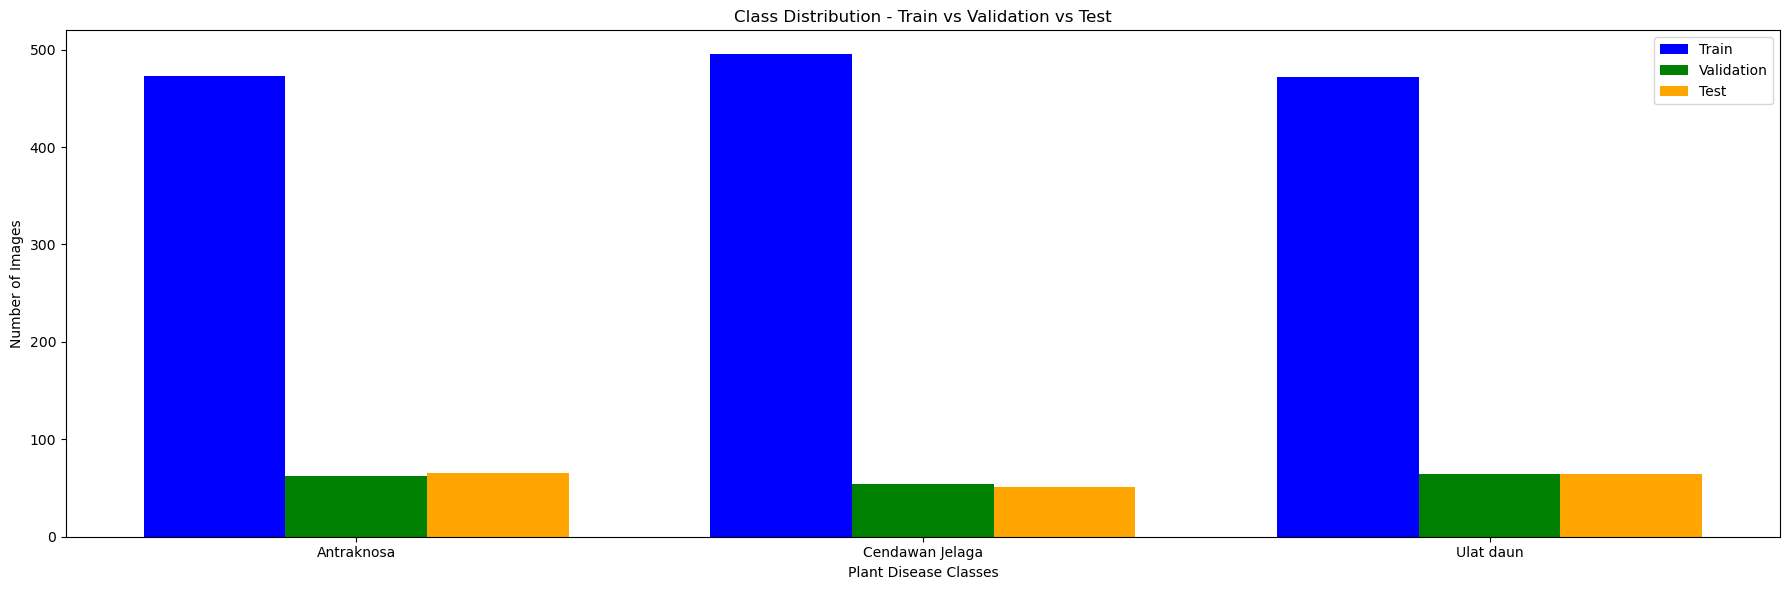

In [7]:
# Menghitung jumlah sampel per kelas untuk data pelatihan, validasi, dan pengujian
train_class_counts = np.bincount(train_labels)  # Jumlah sampel kelas untuk data pelatihan
val_class_counts = np.bincount(val_labels, minlength=len(all_labels))  # Jumlah sampel kelas untuk data validasi
test_class_counts = np.bincount(test_labels, minlength=len(all_labels))  # Jumlah sampel kelas untuk data pengujian

# Mendefinisikan label kelas yang digunakan dalam dataset
classes = all_labels  # Label kelas

# Warna batang untuk setiap subset
train_colors = 'blue'      # Warna batang untuk data pelatihan
val_colors = 'green'       # Warna batang untuk data validasi
test_colors = 'orange'     # Warna batang untuk data pengujian

# Lebar batang grafik
bar_width = 0.25  # Lebar batang grafik
index = np.arange(len(classes))  # Posisi batang
plt.figure(figsize=(18, 6))  # Ukuran gambar

# Membuat grafik batang untuk distribusi data pelatihan
plt.bar(index, train_class_counts, width=bar_width, color=train_colors, label='Train')  # Grafik batang untuk data pelatihan

# Membuat grafik batang untuk distribusi data validasi
plt.bar(index + bar_width, val_class_counts, width=bar_width, color=val_colors, label='Validation')  # Grafik batang untuk data validasi

# Membuat grafik batang untuk distribusi data pengujian
plt.bar(index + 2 * bar_width, test_class_counts, width=bar_width, color=test_colors, label='Test')  # Grafik batang untuk data pengujian
plt.xlabel("Plant Disease Classes")  # Label untuk sumbu X
plt.ylabel("Number of Images")  # Label untuk sumbu Y
plt.title("Class Distribution - Train vs Validation vs Test")  # Judul grafik
plt.xticks(index + bar_width, classes)  # Label kelas pada sumbu X
plt.legend()  # Menampilkan legenda

# Menyesuaikan tata letak agar semua elemen terlihat dengan baik
plt.tight_layout()  # Menyesuaikan layout
plt.show()  # Menampilkan grafik

# Pre Prosesing Data

In [8]:
# Normalize image data (convert pixel values to range 0-1)
x_train = np.array(train_images, dtype=np.float16) / 255.0  # Normalisasi data pelatihan
x_val = np.array(val_images, dtype=np.float16) / 255.0      # Normalisasi data validasi
x_test = np.array(test_images, dtype=np.float16) / 255.0    # Normalisasi data pengujian

# Convert labels to categorical (one-hot encoding)
y_train = to_categorical(np.array(train_labels), num_classes=len(classes))  # One-hot encoding untuk data pelatihan
y_val = to_categorical(np.array(val_labels), num_classes=len(classes))      # One-hot encoding untuk data validasi
y_test = to_categorical(np.array(test_labels), num_classes=len(classes))    # One-hot encoding untuk data pengujian

# Menampilkan bentuk (shape) data untuk pelatihan, validasi, dan pengujian
print("x_train shape:", x_train.shape)  # Dimensi data pelatihan
print("x_val shape:", x_val.shape)      # Dimensi data validasi
print("x_test shape:", x_test.shape)    # Dimensi data pengujian
print("y_train shape:", y_train.shape)  # Dimensi label pelatihan
print("y_val shape:", y_val.shape)      # Dimensi label validasi
print("y_test shape:", y_test.shape)    # Dimensi label pengujian


x_train shape: (1440, 256, 256, 3)
x_val shape: (180, 256, 256, 3)
x_test shape: (180, 256, 256, 3)
y_train shape: (1440, 3)
y_val shape: (180, 3)
y_test shape: (180, 3)


# Visualization

# a. Sample Train Images

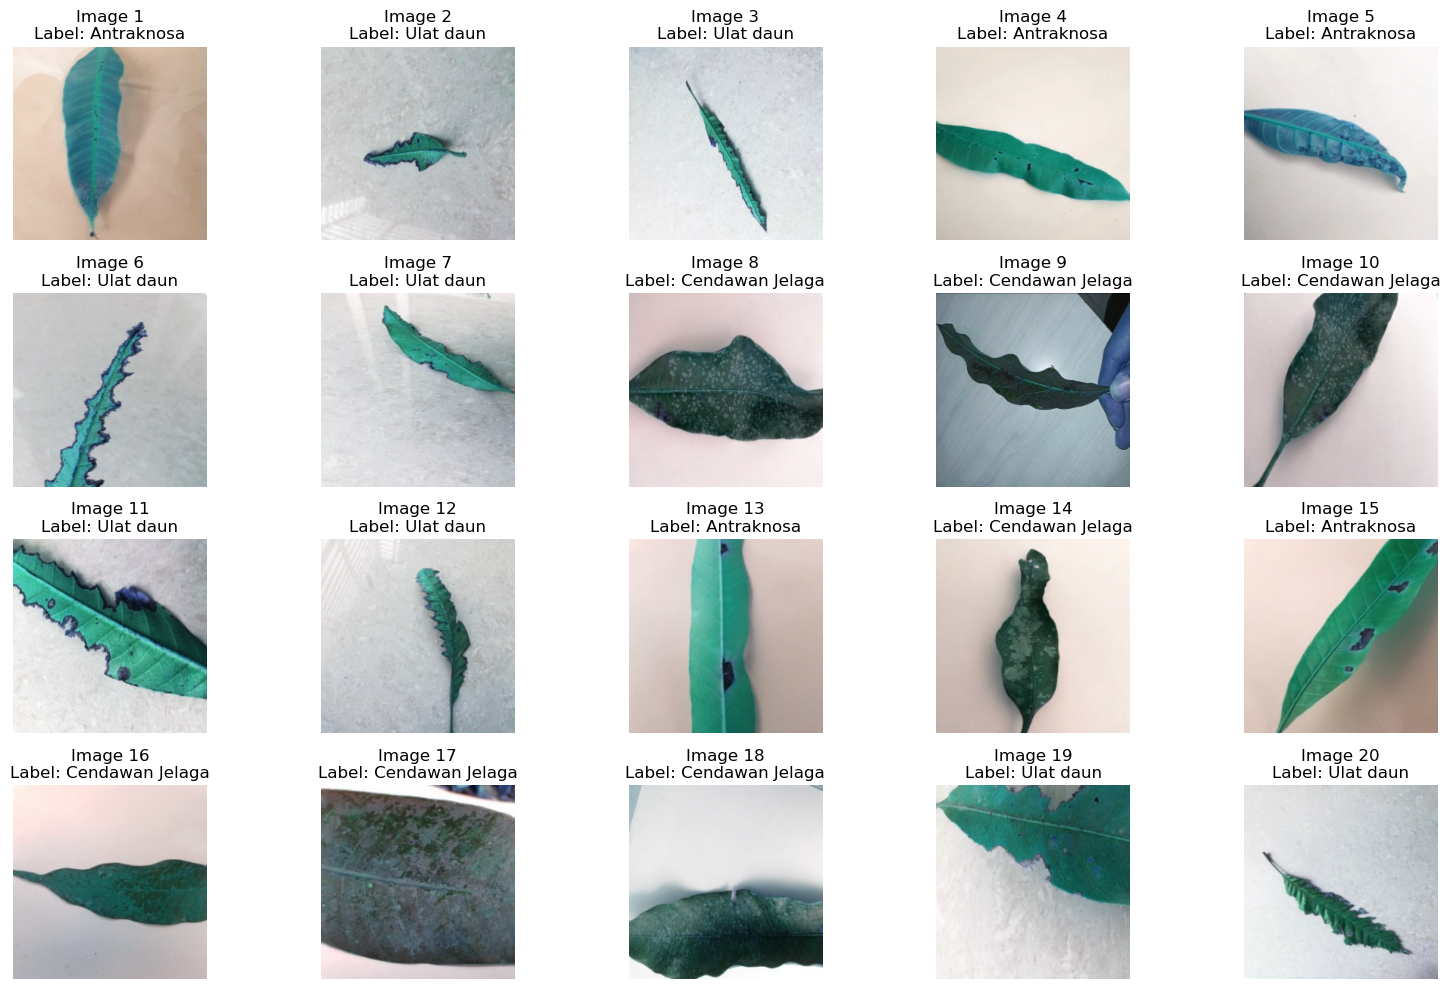

In [9]:
plt.figure(figsize=(16, 10))
sample_indices = random.sample(range(len(x_train)), 20) # Pilih 20 sampel secara acak dari data Train

for i, idx in enumerate(sample_indices):
    plt.subplot(4, 5, i + 1)
    plt.imshow(array_to_img(x_train[idx]))
    label = np.argmax(y_train[idx])
    plt.title(f"Image {i + 1}\nLabel: {all_labels[label]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# b. Sample Val Images

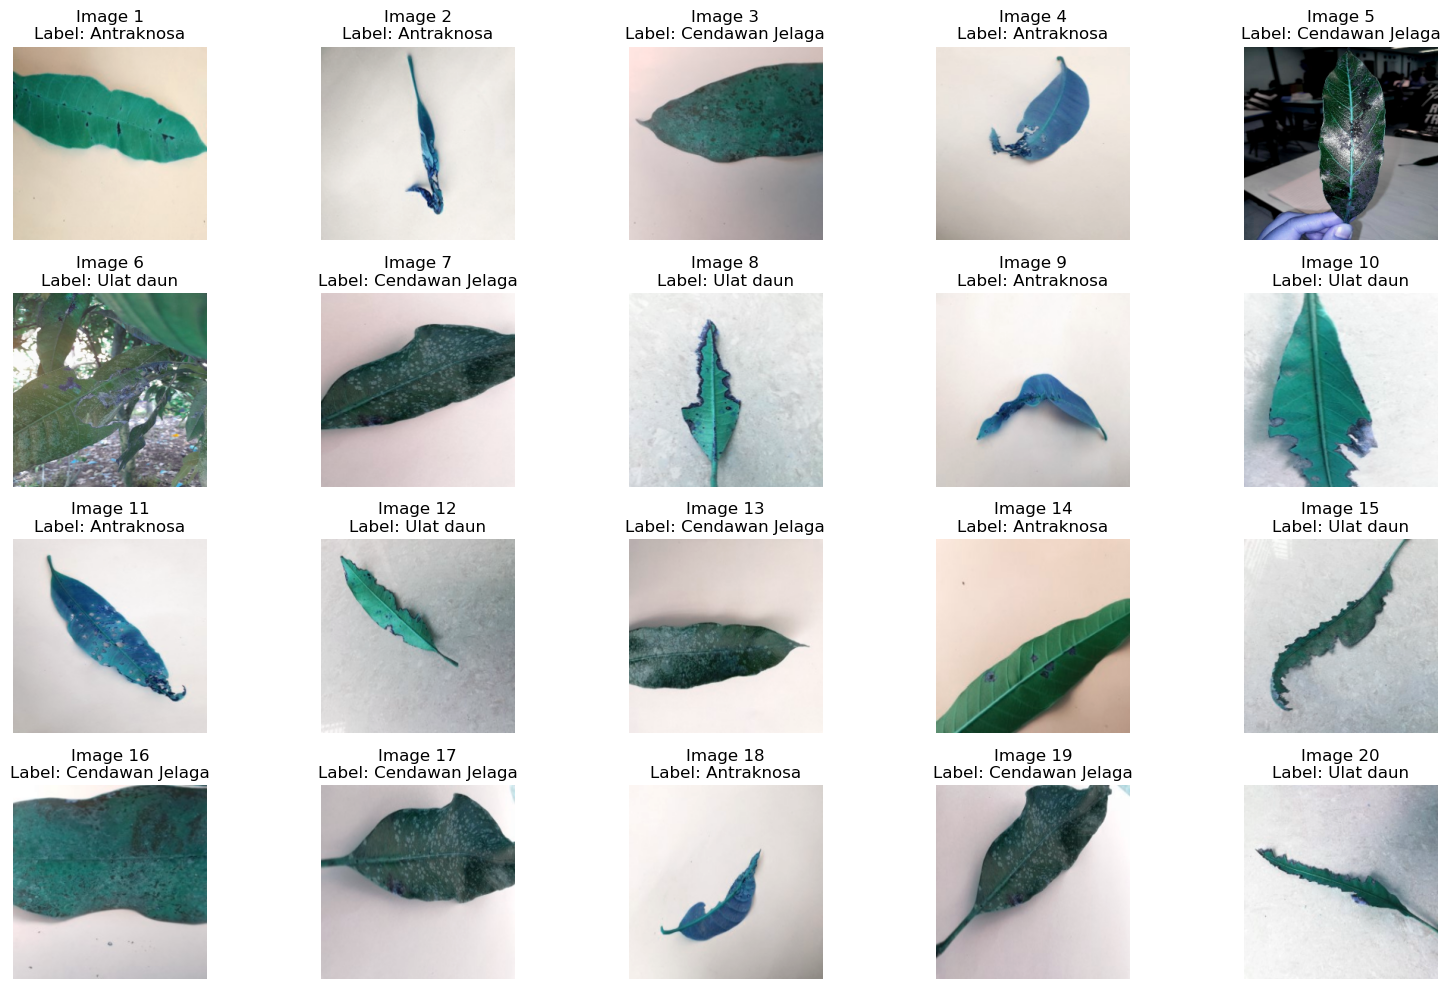

In [10]:
# Menampilkan 20 sampel gambar dari data validasi
plt.figure(figsize=(16, 10))
sample_indices = random.sample(range(len(x_val)), 20)  # Pilih 20 sampel secara acak dari data validasi

for i, idx in enumerate(sample_indices):
    plt.subplot(4, 5, i + 1)  # Menyusun gambar dalam grid 4x5
    plt.imshow(array_to_img(x_val[idx]))  # Menampilkan gambar dari data validasi
    label = np.argmax(y_val[idx])  # Mengambil label satu-hot encoding
    plt.title(f"Image {i + 1}\nLabel: {all_labels[label]}")  # Menambahkan judul dengan label kelas
    plt.axis('off')  # Menyembunyikan axis pada gambar
plt.tight_layout()  # Menata layout gambar
plt.show()  # Menampilkan gambar


# c. Sample Test Images

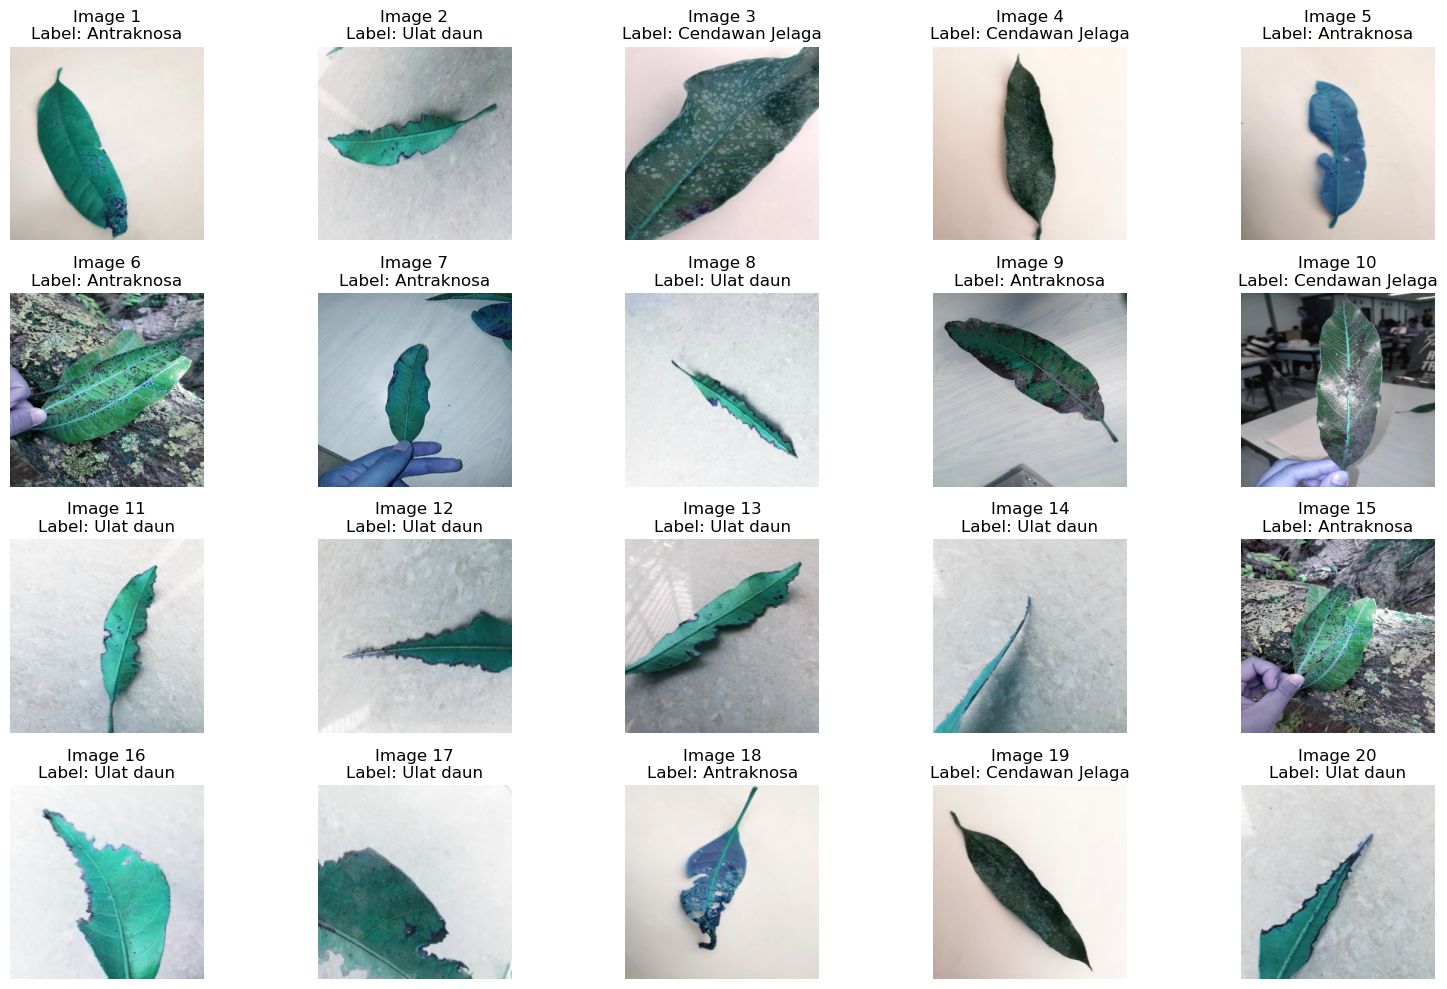

In [11]:
plt.figure(figsize=(16, 10))
sample_indices = random.sample(range(len(x_test)), 20) # Pilih 20 sampel secara acak dari data Test

for i, idx in enumerate(sample_indices):
    plt.subplot(4, 5, i + 1)
    plt.imshow(array_to_img(x_test[idx]))
    label = np.argmax(y_test[idx])
    plt.title(f"Image {i + 1}\nLabel: {all_labels[label]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Model Definition

In [21]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2

# Model VGG16
def build_vgg16_model(input_shape=(256, 256, 3), num_classes=len(classes)):
    # Memuat model dasar VGG16 tanpa lapisan klasifikasi atas
    base_model = VGG16(include_top=False, input_shape=input_shape)
    
    model = Sequential([
        base_model,  # Menambahkan model VGG16 sebagai fitur ekstraksi
        GlobalAveragePooling2D(),  # Global Average Pooling untuk mengurangi dimensi
        Dense(1024, activation='relu', kernel_regularizer=l2(0.01)),  # Fully connected layer dengan regularisasi L2
        Dropout(0.6),  # Dropout untuk mengurangi overfitting
        Dense(num_classes, activation='softmax')  # Lapisan output dengan softmax untuk multi-class classification
    ])
    
    return model

# Contoh penggunaan untuk dataset
vgg16_model = build_vgg16_model(input_shape=(256, 256, 3), num_classes=len(classes))
vgg16_model.summary()  # Menampilkan ringkasan model untuk melihat arsitektur


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 8, 8, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,243,075 (58.15 MB)

 Trainable params: 15,243,075 (58.15 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

def build_vgg16_with_flatten(input_shape=(256, 256, 3), num_classes=len(classes)):
    base_model = VGG16(include_top=False, input_shape=input_shape)
    
    model = Sequential([
        base_model,  # Model VGG16 tanpa lapisan atas
        Flatten(),  # Menggunakan Flatten untuk mengubah output 2D menjadi 1D
        Dense(1024, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.6),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Contoh penggunaan
vgg16_model_flatten = build_vgg16_with_flatten(input_shape=(256, 256, 3), num_classes=len(classes))
vgg16_model_flatten.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 8, 8, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      33,555,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,273,219 (184.15 MB)

 Trainable params: 48,273,219 (184.15 MB)

 Non-trainable params: 0 (0.00 B)

# Model Training

Training VGG16 model...
Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 294s 5s/step - accuracy: 0.5362 - loss: 17.0964 - val_accuracy: 0.8095 - val_loss: 8.1013
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 277s 5s/step - accuracy: 0.9000 - loss: 6.6533 - val_accuracy: 0.9610 - val_loss: 3.7920
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 279s 5s/step - accuracy: 0.9313 - loss: 3.3902 - val_accuracy: 0.9264 - val_loss: 2.5816
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 279s 5s/step - accuracy: 0.9504 - loss: 2.2365 - val_accuracy: 0.9567 - val_loss: 1.7659
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 279s 5s/step - accuracy: 0.9562 - loss: 1.6724 - val_accuracy: 0.9394 - val_loss: 1.3985
Epoch 6/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 279s 5s/step - accuracy: 0.9634 - loss: 1.3030 - val_accuracy: 0.9481 - val_loss: 1.1486
Epoch 7/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 278s 5s/step - accuracy: 0.9812 - loss: 1.0406 - val_accuracy: 0.9351 - val_loss: 1.1349
Epoch 8/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 277s 5s/step - accuracy: 0.9408 - loss: 1.0320 -

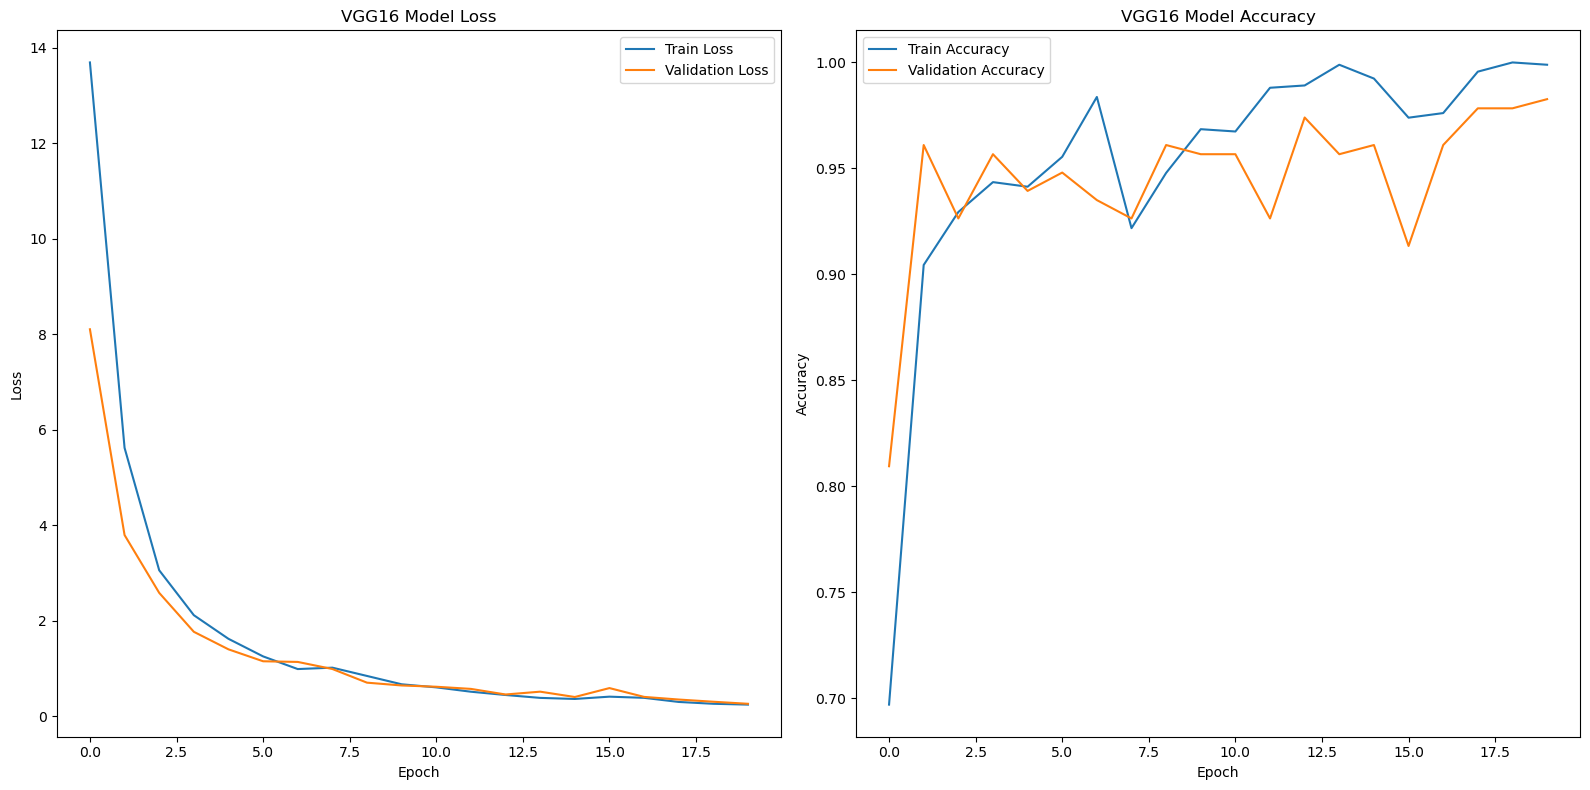

In [14]:
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Membagi data pelatihan menjadi data pelatihan dan validasi
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Training VGG16
print("Training VGG16 model...")
vgg16_model = build_vgg16_with_flatten(input_shape=(256, 256, 3), num_classes=len(classes))  # Menyesuaikan jumlah kelas
vgg16_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history_vgg16 = vgg16_model.fit(
    x_train, y_train,  # Menggunakan data pelatihan dan label pelatihan
    batch_size=16,     # Ukuran batch untuk pelatihan
    epochs=20,         # Jumlah epoch untuk pelatihan
    validation_data=(x_val, y_val),  # Data validasi untuk evaluasi
    verbose=1  # Menampilkan progres pelatihan
)

# Menyimpan model dan sejarah pelatihan
history_dict_vgg16 = history_vgg16.history

# Plot Loss dan Accuracy
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Plot Loss
ax[0].plot(history_dict_vgg16['loss'], label='Train Loss')
ax[0].plot(history_dict_vgg16['val_loss'], label='Validation Loss')
ax[0].set_title('VGG16 Model Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plot Accuracy
ax[1].plot(history_dict_vgg16['accuracy'], label='Train Accuracy')
ax[1].plot(history_dict_vgg16['val_accuracy'], label='Validation Accuracy')
ax[1].set_title('VGG16 Model Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()


# Model Testing

Evaluating VGG16 model on test data...
VGG16 Test Accuracy: 96.11%
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step


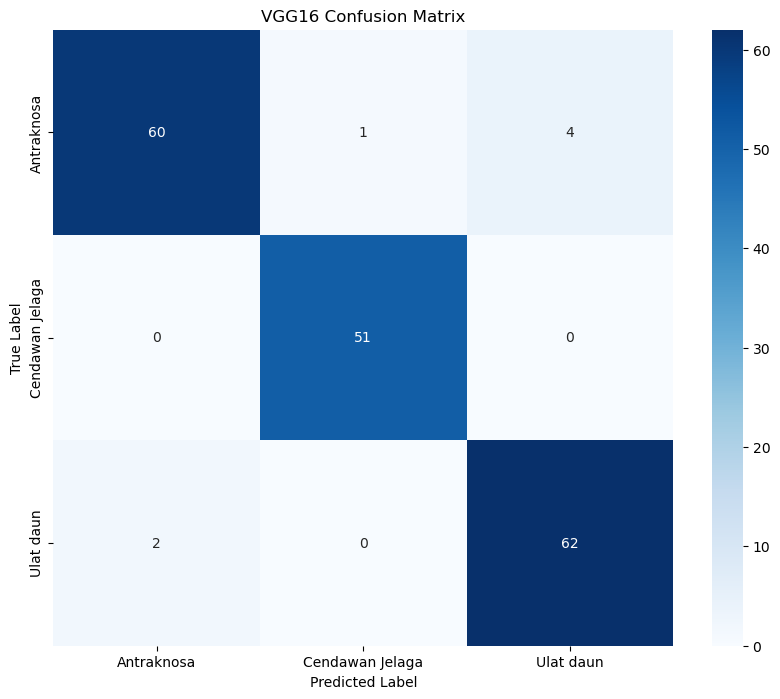

                 precision    recall  f1-score   support

     Antraknosa       0.97      0.92      0.94        65
Cendawan Jelaga       0.98      1.00      0.99        51
      Ulat daun       0.94      0.97      0.95        64

       accuracy                           0.96       180
      macro avg       0.96      0.96      0.96       180
   weighted avg       0.96      0.96      0.96       180



In [15]:
from sklearn.metrics import confusion_matrix, classification_report

print("Evaluating VGG16 model on test data...")

# Evaluasi pada data uji
scores_vgg16 = vgg16_model.evaluate(x_test, y_test, verbose=0)
print(f"VGG16 Test Accuracy: {scores_vgg16[1] * 100:.2f}%")

# Prediksi
y_pred_vgg16 = np.argmax(vgg16_model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm_vgg16 = confusion_matrix(y_true, y_pred_vgg16)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_vgg16, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("VGG16 Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred_vgg16, target_names=classes))


In [16]:
import cv2
import numpy as np

def preprocess_for_display(image):
    """
    Pastikan gambar berada di RGB dan rentang nilai [0, 255].
    """
    # Jika gambar normalisasi dalam rentang [0, 1], ubah ke [0, 255]
    if np.max(image) <= 1.0:
        image = image * 255
    # Pastikan format uint8
    image = image.astype("uint8")
    # Konversi BGR ke RGB jika menggunakan OpenCV
    if image.shape[-1] == 3:  # Jika gambar memiliki 3 channel
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


In [17]:
# Daftar nama kelas
classes = ['Antraknosa', 'Cendawan Jelaga', 'Ulat Daun']  # Sesuaikan dengan model Anda


In [18]:
def output_plot(image, model, classes):
    """
    Menampilkan gambar input dan prediksi dari model.
    """
    # Preprocessing gambar untuk ditampilkan
    image_display = preprocess_for_display(image)
    
    plt.imshow(image_display)
    plt.axis('off')
    
    # Prediksi
    prediction = model.predict(np.expand_dims(image, axis=0))  # Tambahkan dimensi batch
    predicted_class = classes[np.argmax(prediction)]
    confidence = np.max(prediction) * 100
    
    plt.title(f"Predicted: {predicted_class} ({confidence:.2f}%)")
    plt.show()




Testing - VGG16 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


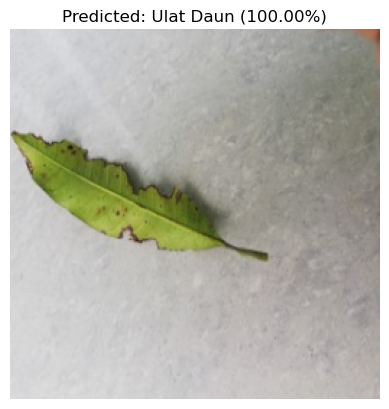



Testing - VGG16 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


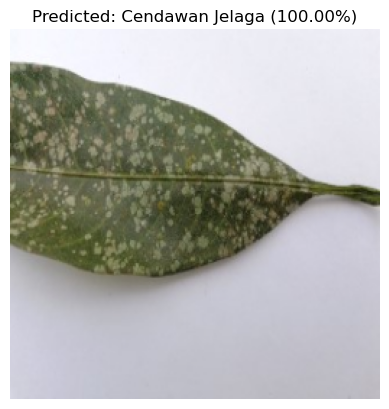



Testing - VGG16 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


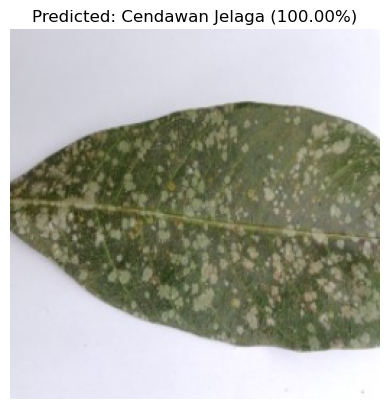



Testing - VGG16 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


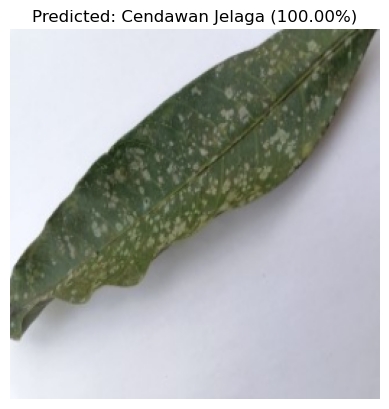



Testing - VGG16 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


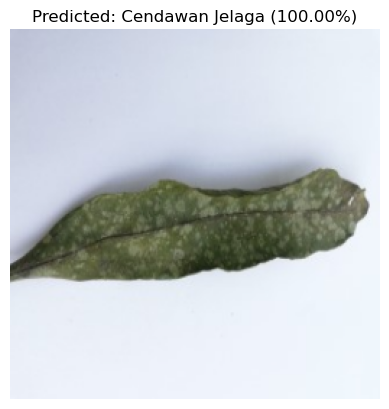



Testing - VGG16 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


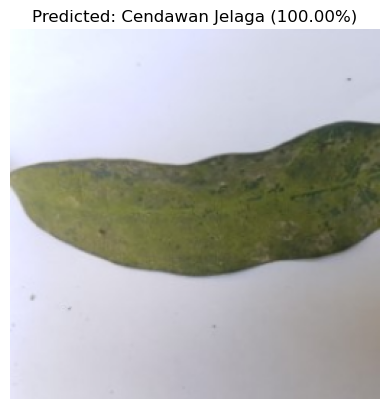



Testing - VGG16 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


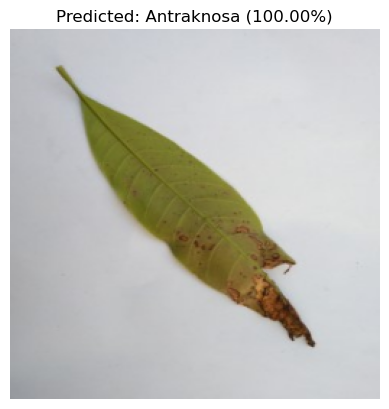



Testing - VGG16 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


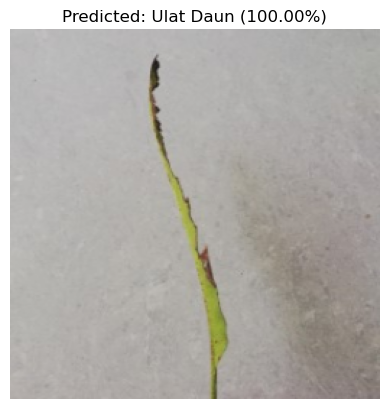



Testing - VGG16 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


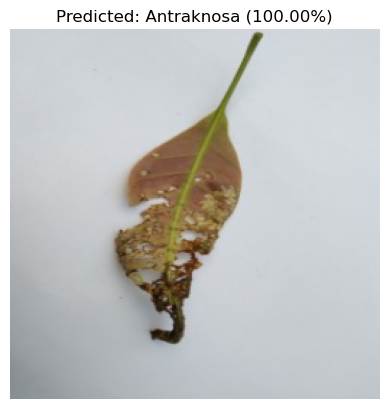



Testing - VGG16 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


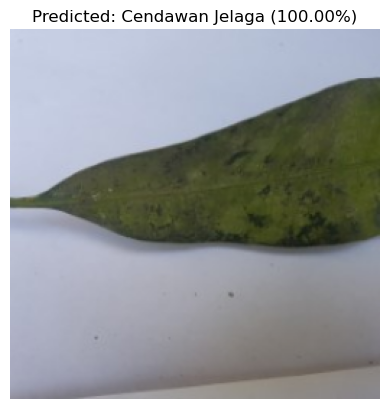



Testing - VGG16 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


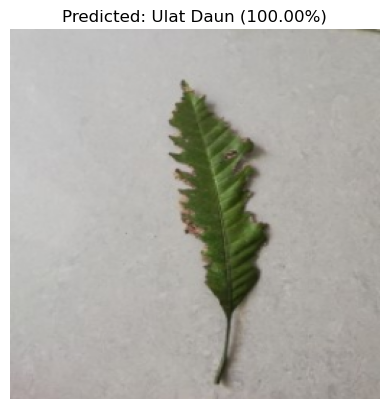



Testing - VGG16 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


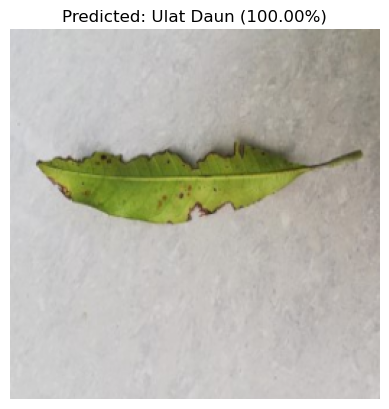



Testing - VGG16 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


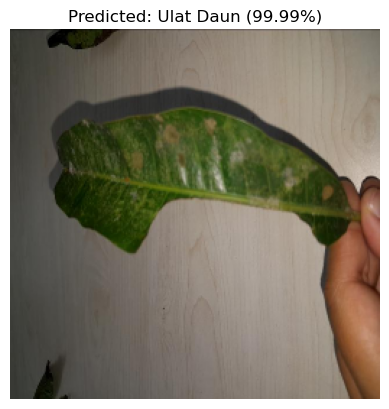



Testing - VGG16 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


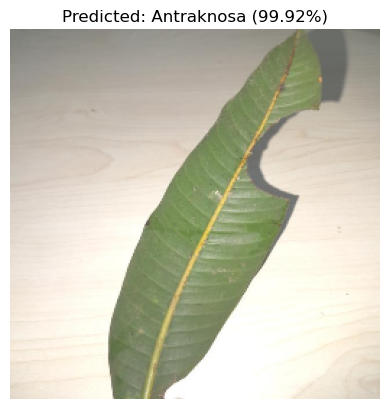



Testing - VGG16 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


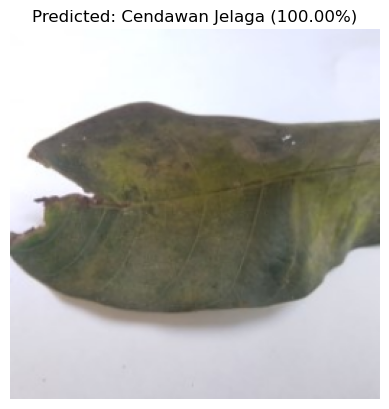



Testing - VGG16 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


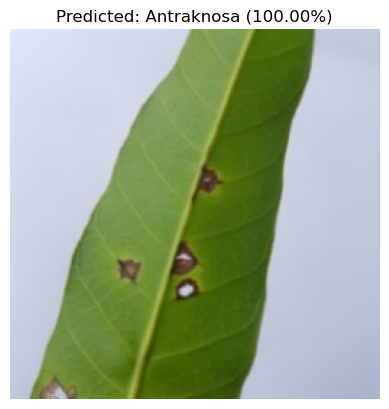



Testing - VGG16 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


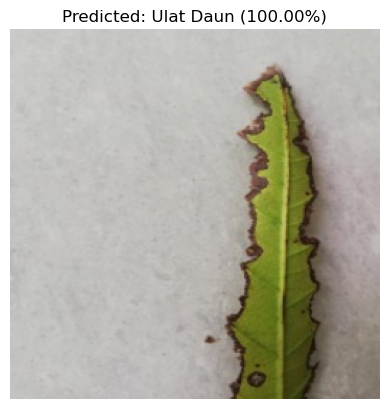



Testing - VGG16 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


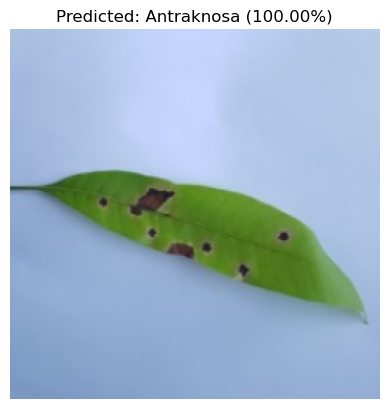



Testing - VGG16 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


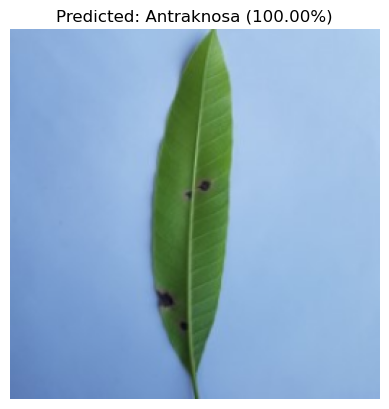



Testing - VGG16 Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


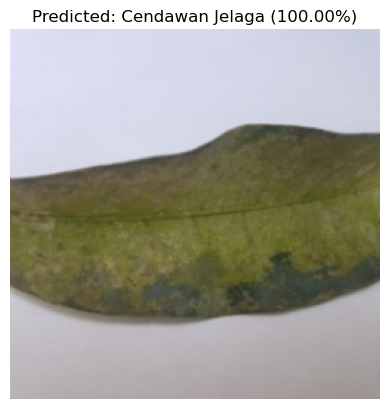

In [19]:
# Testing untuk beberapa gambar dari dataset uji
for i in range(30, 50):  # Pilih indeks gambar uji
    print(f"\n\nTesting - VGG16 Model\n")
    output_plot(x_test[i], vgg16_model, classes)


In [21]:
model = build_vgg16_with_flatten()  # Panggil fungsi untuk membangun model
model.save_weights('model_VGG16.weights.h5')  # Simpan bobot model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


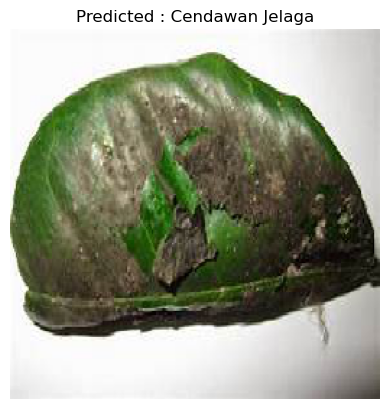

In [23]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Tetapkan label kelas secara manual
class_labels = ['Antraknosa', 'Cendawan Jelaga', 'Ulat Daun']  # Ganti dengan label yang sesuai

# Muat model dan bobot
model_path = 'C:/Users/USER/PM/TESTING/Version 1/model_VGG16.weights.h5'
model = build_vgg16_with_flatten()  
model.load_weights(model_path)

def predict_and_display(image_path, model, class_labels):
    img = image.load_img(image_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)

    predicted_class_label = class_labels[predicted_class_index]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted : {predicted_class_label}")
    plt.show()

# Path ke gambar uji
image_path_to_test = 'C:/Users/USER/PM/TESTING/th.jpg'

# Prediksi dan tampilkan hasil
predict_and_display(image_path_to_test, model, class_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


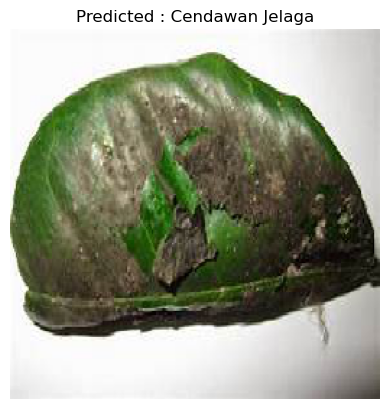

In [30]:
image_path_to_test = 'C:/Users/USER/PM/TESTING/th.jpg'
predict_and_display(image_path_to_test, model, class_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


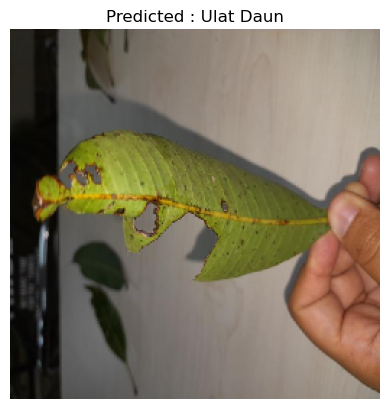

In [34]:
image_path_to_test = 'C:/Users/USER/PM/TESTING/5.jpg'
predict_and_display(image_path_to_test, model, class_labels)